# Sistemas Inteligentes

## Curso académico 2024-2025

### Práctica 1: Búsqueda en espacio de estados

#### Grupo 9

* Alberto Pérez Álvarez: alberto.perez25@alu.uclm.es
* Marcos López Gómez: marcos.lopez14@alu.uclm.es


## Estructura de datos
Hemos dividido las estructuras de datos en clases, una para cada entidad como se recomienda. Asi tenemos las clases de estructuras básicas Estado, Accion, Problema y Nodo. Además de las básicas, también tenemos las clases Busqueda, BusquedaInformada, AEstrella, seguida de otra clase Heuristica para las heuristicas; y aparte de las anteriores, utilizadas en la práctica 1 también tenemos las clases evolutivoGeneral, evolutivoFitness, evolutivoRango y evolutivoTorneo

## 0.1 Importaciones
Imports necesarios para el código. Para usar Plot() se deberia poner en la misma ruta que el diccionario.

In [557]:
#Clases básicas:
import json
from math import sqrt
import math

#Clase búsqueda
from abc import ABC, ABCMeta,abstractmethod # Clases abstractas
import time

#Clase heurística
from math import sqrt

# Busqueda Informada
from heapq import heappush, heappop # Para la PriorityQueue

# Libreria que calcula de manera exacta la distancia geodesica
from geopy.distance import geodesic 

# Para hacer gráficos de la mejor solución en cada iteracion
import matplotlib.pyplot as plt

import random

## 1. AEstrella


Dentro de este apartado consideramos las clases básicas (Estado, Accion, Problema, Nodo), la clase Heurística, la clase Busqueda y las clases BusquenaInformada y AEstrella.

### 1.1. Clases Básicas

Dentro de este archivo están las clases: Estado, que contiene atributos para almacenar los datos referentes a una intersección. Accion, que tiene atributos para almacenar un segmento del JSON; Problema, cuyo metodo init carga la información del JSON, y que a diferencia de en la practica 1, ya no tiene inicial y final; y Nodo, en cuyos atributos se almacena la informacion referente a un nodo.

In [558]:
#Interseccion:
class Estado:
    def __init__(self, id, latitude, longitude):
        self.identifier = id
        self.latitude = latitude
        self.longitude = longitude
    def __str__(self):
        return f"Interseccion: (id={self.identifier}, latitud={self.latitude}, longitud={self.longitude})"
    def __repr__(self):
        return f"{self.identifier}"
    def __eq__(self, otro):
        if not isinstance(otro, Estado):
            return False
        else:
            return self.identifier == otro.identifier
    def __lt__(self, otro):
        return self.identifier < otro.identifier

#Segmento:    
class Accion:
    def __init__(self, origin, destination, distance, speed):
        self.origin = origin
        self.destination = destination
    # Dan la velocidad en Km/h y la distancia en m
        self.time = (distance/(speed*(10/36))) # Usamos: D->m. T->s y V->m/s
    def __str__(self):
        return f"Calle: Origen: {self.origin}, Destino: {self.destination})"
    def __repr__(self):
        return f"{self.origin} → {self.destination} ({self.time})"
    def __eq__(self, otro):
        if not isinstance(otro, Accion):
            return False
        else:
            return self.origin == otro.origin and self.destination == otro.destination and self.time == otro.time
    def __lt__(self, otro):
        return self.destination < otro.destination
    
class Problema:   
    #Constructor de Problema
    def __init__(self,ruta):
        with open(ruta, 'r') as file:
            self.data = json.load(file)
        
        self.dic_estados = {}
        self.dic_acciones = {}
        self.maxSpeed = 0
        self.dic_candidatos = []
        self.candidatos = self.data['candidates']
        self.number_stations = self.data['number_stations']

        # Pasamos las intersecciones del JSON a un nuevo diccionario estados
        for inter in self.data['intersections']:
            self.dic_estados.update({inter['identifier']:(Estado(inter['identifier'], inter['latitude'], inter['longitude']))})         
            self.dic_acciones.update({inter['identifier']:[]})  # Acciones = {id:Lista de Acciones}
            #editar

        #QUITAMOS INICIAL Y FINAL YO NO ESTAN EN EL JSON

        # Pasamos los segmentos del JSON a un nuevo diccionario acciones   
        segOrd = self.data['segments']; #Ordenamos la  
        for seg in segOrd:
            if (seg['speed']*(10/36) > self.maxSpeed):
                self.maxSpeed = seg['speed']*(10/36) # km/h -> m/s
            accion=Accion(seg['origin'], seg['destination'], seg['distance'], seg['speed'])
            self.dic_acciones[seg['origin']].append(accion)  # Metemos las acciones de cada Estado en una lista ordenada

        # Ordenamos las acciones de cada estado
        for id in self.dic_acciones:
            self.dic_acciones[id].sort(key=lambda x: x.destination)


    # Obtener un objeto Estado a partir de su ID
    def getEstado(self, id):
        return self.dic_estados[id]

    # Obtener todas las acciones de un estado a partir de su ID
    def getAccionesDe(self,id):
        return self.dic_acciones[id]

class Nodo:
    def __init__(self, interseccion, padre = None, accionTomada = None, coste = 0, profundidad = 0, nGenerado = 0):
        self.estado = interseccion
        self.padre = padre
        self.accion = accionTomada
        self.coste = coste
        self.profundidad = profundidad
        self.nGenerado = nGenerado  # El 1º generado deberia empezar en 1 no en 0, pues dijo en clase que   
                                    # se deberia contar pero ellos no lo cuentan en sus soluciones, asi que 
                                    # nosotros tampoco
    def __str__(self):
        return f"Nodo(estado={self.estado}, padre={self.padre}, accion={self.accion}, coste={self.coste}, profundidad={self.profundidad})"
    def __repr__(self):
        return f"{self.estado.identifier}"
    def __eq__(self,otro):
        if not isinstance(otro, Nodo):
            return False
        return self.estado==(otro.estado) and self.nGenerado.__eq__(otro.nGenerado)
    def __lt__(self,otro):
        return self.estado<(otro.estado)

### 1.2. Clase Heurística

La clase Heurística es una clase abstracta que implementa métodos que son comunes en las clases Heuristica1, Heuristica2, Heuristica3; las cuales heredan de Heurística y cuya única diferencia entre ellas es la manera en la que se calcula la distancia.

In [559]:
class Heuristica(ABC):
    def __init__(self,problema):
        self.problema = problema
    
    @abstractmethod
    def distancia(self,estado,final):
        pass

    # Devuelve el tiempo estimado (coste) desde un estado hasta el estado final
    def tiempo(self, distancia):
        return distancia/self.problema.maxSpeed # D->m V->m/s T->s
    
    # Metodo al que llamamos para calcular la heurística.
    def heuristica(self, nodo, final):
        return self.tiempo(self.distancia(nodo.estado,final))
    
# Dos maneras de hacer heuristicas calculando distancias
class Heuristica1(Heuristica):
    # Euclidea. Pitagoras. (Línea recta)
    def distancia(self, estado, final):
        return sqrt((estado.latitude - final.latitude)**2 + (estado.longitude - final.longitude)**2)*100000
    
class Heuristica2(Heuristica):
    # Geodesica. (Línea recta + curvatura de la Tierra)
    def distancia(self, estado, final):
        return geodesic((estado.latitude,estado.longitude), (final.latitude,final.longitude)).meters # La usan en las soluciones. Mas exacta al ser la tierra una elipse
    # https://pypi.org/project/geopy/
    # https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://geopy.readthedocs.io/&ved=2ahUKEwiWq97Su7OJAxUt_7sIHanJI7kQFnoECBYQAQ&usg=AOvVaw01VCwbF-UadfgLzmTCV4Mo

class Heuristica3(Heuristica):
    # Distancia de Manhattan. Diferencia en latitudes y longitudes.
    def distancia(self,estado,final):
        return abs(estado.latitude - final.latitude) + abs(estado.longitude - final.longitude)
    
class Heuristica4(Heuristica):
    # Harvesine. Ligeramente peor que Geodesica, aumenta rendimiento para el evolutivo.
    def distancia(self, estado, final):

        # Pasar latitudes a radianes
        lonOrigen, latOrigen, lonDestino, latDestino = map(math.radians, [estado.longitude, estado.latitude, final.longitude, final.latitude])

        r = 6371 # El radio de la tierra
        a = math.sin((latDestino - latOrigen)/2)**2 + math.cos(latOrigen) * math.cos(latDestino) * math.sin((lonDestino - lonOrigen)/2)**2
        c = 2 * math.asin(sqrt(a)) 
        return c * r * 1000 # Pasar a a metros
    

### 1.3 Clase Búsqueda

La clase Búsqueda es una clase abstracta que contiene la lógica principal de los algoritmos de búsqueda. Los métodos abstractos de esta clase los implementa BusquedaInformada. Para esta practica 2 hemos añadido a esta clase dos atributos, una cache y un booleano que se utiliza para saber si la cache se utiliza o no.

In [560]:
class Busqueda(ABC):
    def __init__(self, problema, cacheIntermediaActivada = False):
        self.frontera = None # Se inicializará al tipo que le corresponda a cada algoritmo
        self.problema = problema
        self.cerrados = None        # Para no volver a expandir nodos ya visitados
        self.inicial = None
        self.nodo = None
        self.final = None
        self.cache = {}
        self.cacheIntermediaActivada = cacheIntermediaActivada

    def nuestraCache(self, inicial, destino, coste):
        # Crear la key de la cache con inicial y destino
        key_cache = (inicial, destino)
        
        # Comprobamos si esta en la cache
        if key_cache in self.cache:
            return self.cache[key_cache]
        
        # Si no esta en la cache, guardamos el coste
        self.cache[key_cache] = coste

    def expandir(self,nodo,problema):
        acciones = problema.getAccionesDe(nodo.estado.identifier)        
        for accion in acciones: 
            # Cambiado a for porque ahora es una lista segmentos
            sucesor = Nodo(problema.getEstado(accion.destination))
            sucesor.padre = nodo
            sucesor.accion = accion
            sucesor.coste = nodo.coste + accion.time
            if (sucesor.estado.identifier in self.problema.candidatos[0]):
                #self.nuestraCache(nodo.estado.identifier, sucesor.estado.identifier, sucesor.coste)
                self.nuestraCache(self.inicial.identifier,sucesor.estado.identifier,sucesor.coste)
            sucesor.profundidad = nodo.profundidad + 1
            self.añadirNodoAFrontera(sucesor, self.frontera)    # Añadimos los sucesores a frontera.
                                                                # Nos ahorramos un bucle For al añadirlos 
                                                                # desde expandir
    def busqueda(self,inicial,final):
        self.inicial = self.problema.getEstado(inicial)
        self.nodo = Nodo(self.inicial)
        self.final = self.problema.getEstado(final)
        self.cerrados = set()        # Para no volver a expandir nodos ya visitados
        self.vaciar_frontera()
        self.añadirNodoAFrontera(self.nodo,self.frontera)
        while(not self.esVacia(self.frontera)): 
            self.nodo = self.extraerNodoDeFrontera(self.frontera)
            if (self.nodo.estado == (self.final)):     # Cambio de .eq a ==
                return self.nodo.coste 
            if (not self.nodo.estado.identifier in self.cerrados):
                if(( self.cacheIntermediaActivada 
                     and self.nodo.estado.identifier, self.final.identifier) in self.cache):                  # Cache intermedia. Empeora el fitness pero       
                    return self.cache[(self.nodo.estado.identifier, self.final.identifier)] + self.nodo.coste # reduce el tiempo a la mitad en algunos casos.
                self.expandir(self.nodo, self.problema)     # Obtenemos los sucesores con Expandir()        
                self.cerrados.add(self.nodo.estado.identifier)
        return 18000 #3600 * 5

    @abstractmethod
    def añadirNodoAFrontera(self, nodo, frontera):
        pass
    @abstractmethod
    def extraerNodoDeFrontera(self, frontera):
        pass
    @abstractmethod
    def esVacia(self, frontera):
        pass
    @abstractmethod
    def vaciar_frontera(self):
        pass

### 1.4 Búsqueda Informada, Aestrella

La clase BusquedaInformada es una clase abstracta que hereda de Busqueda, y que implementa todos sus metodos excepto añadirNodoAFrontera, el cual lo implementa la clase AEstrella, que hereda de BusquedaInformada. Además de lo que ya estaba de la Practica 1 hemos añadido una cache que almacena heuristicas para no tener que volver a calcularlas.

In [561]:
class BusquedaInformada(Busqueda,metaclass=ABCMeta):
    def __init__(self, problema, heuristica, cacheIntermediaActivada=False):
        super().__init__(problema, cacheIntermediaActivada)
        #self.frontera = PriorityQueue() 
        self.frontera = []# Frontera se usará como PriorityQueue de nodos a ser expandidos
        self.H = heuristica
        self.cacheHeuristica = {}
    @abstractmethod
    def añadirNodoAFrontera(self, nodo, frontera):
        pass

    def extraerNodoDeFrontera(self, frontera):  # Igual en PrimeroMejor y AEstrella
        return heappop(frontera)[1]             # Sacamos el nodo que toca
    
    def esVacia(self, frontera):                # Igual en PrimeroMejor y AEstrella
        return len(frontera) == 0
    
    def vaciar_frontera(self):                  # Igual en PrimeroMejor y AEstrella
        #self.frontera = PriorityQueue()
        self.frontera = []

    def cache_heuristica(self, nodo):
        # Crear la key de la cache con el id del estado del nodo
        key_cache = (nodo.estado.identifier)
        
        # Comprobamos si esta en la cache
        if key_cache in self.cacheHeuristica:
            return self.cacheHeuristica[key_cache]
        
        # Si no esta en la cache, guardamos el coste
        resultado = self.H.heuristica(nodo, self.final)
        self.cacheHeuristica[key_cache] = resultado
        return resultado

class AEstrella(BusquedaInformada):
    def añadirNodoAFrontera(self, nodo, frontera):
        gn = nodo.coste   
        hn = self.cache_heuristica(nodo)                # Almacenamos en una cache la heuristica de un estado
        fn = hn + gn    
        heappush(frontera, (fn,  nodo))                                                  
    

## 2. Algoritmo evolutivo

Estas son un conjunto de clases que implementan un algoritmo evolutivo de diferentes maneras, pero con algunas partes comunes.

### 2.1 Evolutivo general

La clase EvolutivoGeneral es una clase abstracta que contiene la logica principal de los algoritmos evolutivos. Es la parte del codigo comun a todos los algoritmos evolutivos, y cuenta con algunos metodos sin implementar, ya que estos son diferentes en cada uno de los algoritmos evolutivos, los cuales heredan de esta clase.

Esta clase cuenta con los atributos "candidatos", que contiene los candidatos, y estos los obtiene del problema; "nSoluciones", que contiene el número de estaciones a elegir y también lo obtiene del problema; "tamPoblacion", que contiene el tamaño de la población del problema; "poblacion", que contiene a la poblacion; "fitness" que contiene el fitness de la población; "mejorFitness" que contiene el mejor fitness obtenido; "mejorIndividuo" que contiene el indice del mejor individuo obtenido; "problema", que contiene el problema; "tasaMutacion" y "tasaCruce" que contienen la probabilidad de que ocurra cruce o mutación respectivamente; "padres" un vector que contiene 2 individuos para cruzarlos; "nGeneracionesMaximas", que contiene el número máximo de generaciones; "tInicial" y "tFinal" que contienen el tiempo inicial y final respectivamente para saber cuanto tardo en ejecutarse el programa; "poblacionDeCandidatos", que contiene la poblacion de un candidato; y "calculadoPoblacionTotalCandidatos", que es un booleano que se utiliza para saber si la poblacion total de candidatos fue calculada previamente.

Ademas la clase evolutivo contiene métodos ya implementados, ya que estos son comunes para el resto de algoritmos, los métodos son: "nuestraCache", que comprueba si se ha calculado aestrella para un inicial y un final, y si no lo calcula y lo almacena; "calcularFitness" que calcula el fitness de un individuo según la formula de la función de evaluacion dada por el profesor; "cruce", que permite cruzar a dos individuos mediante el cruce por un punto; "mutacion" que permite cruzar individuos mediante la mutacion binaria o real; "genético" que es el algoritmo genético en sí; y "formatear tiempo" para imprimir las soluciones.

In [562]:
VMAX = math.inf #Valor Maximo

class Evolutivo(ABC):
    def __init__(self, nGeneracionesMaximas, tamPoblacion , tasaMutacion, tasaCruce, aestrella, problema):
        self.candidatos = problema.candidatos
        self.nSoluciones = problema.number_stations
        if tamPoblacion != None:
            self.tamPoblacion = tamPoblacion
            if tamPoblacion%2!=0:
                self.tamPoblacion = tamPoblacion + 1
        else:
            self.tamPoblacion = (len(self.candidatos)//self.nSoluciones)
        self.poblacion = [0] * self.tamPoblacion
        #self.fitnessSols = [VMAX] * len(self.candidatos)
        self.fitness = [VMAX] * self.tamPoblacion
        self.mejorFitness = VMAX
        self.mejorIndividuo = [0] * self.nSoluciones
        self.aestrella = aestrella
        self.problema = problema
        self.tasaMutacion = tasaMutacion
        self.tasaCruce = tasaCruce
        self.padres = []
        self.nGeneracionesMaximas = nGeneracionesMaximas
        self.tInicio = 0
        self.tFinal = 0
        self.poblacionDeCandidatos = 0
        self.calculadoPoblacionTotalCandidatos = False

    def nuestraCache(self, inicial, final):
        # Creamos la key de la cache con el inicial y final
        cache_key = (inicial, final)
        
        # Comprobamos si está en cache
        if cache_key in self.aestrella.cache:
            return self.aestrella.cache[cache_key]
        
        # Si no esta en cache calculamos y almacenamos en cache
        resultado = self.aestrella.busqueda(inicial, final)
        self.aestrella.cache[cache_key] = resultado
        return resultado

    @abstractmethod
    def inicializarN(self,nSoluciones):
        pass

    def calcularFitness(self,individuo):
        tiempos = 0
        for inicial in self.candidatos: #I
            if not self.calculadoPoblacionTotalCandidatos: 
                self.poblacionDeCandidatos += inicial[1] # inicial[1] es la poblacion de un candidato
            tiempo = VMAX                                # inicial[0] es identificador del inicial
            tiempoMin = VMAX
            for final in individuo: #J
                tiempo = self.nuestraCache(inicial[0],self.candidatos[final][0])
                tiempoMin = min(tiempo,tiempoMin)       # si inicial = final no hacemos if pq tarda mas
            tiempos += tiempoMin * inicial[1]
        self.calculadoPoblacionTotalCandidatos = True
        return tiempos/self.poblacionDeCandidatos
    
    @abstractmethod
    def seleccionGeneracion(self):#Seleccion por torneo
        pass
    
    def cruce(self, padres, indiceCruce):
        hijos = [0] * 2
        hijos[0] = [0] * self.nSoluciones
        hijos[1] = [0] * self.nSoluciones
        nRandom = random.random()
        if (len(str(padres[0]))<indiceCruce and len(str(padres[1]))<indiceCruce or nRandom>self.tasaCruce):
            hijos[0] = padres[0]
            hijos[1] = padres[1]
        else:   
            for i in range(len(padres[0])):
                if i < indiceCruce or padres[1][i] in hijos[0] :
                    hijos[0][i]=padres[0][i]
                else:
                    hijos[0][i]=padres[1][i]

                if i < indiceCruce or padres[0][i] in hijos[1] :
                    hijos[1][i]=padres[1][i]
                else:
                    hijos[1][i]=padres[0][i]
        return hijos

    def mutacion(self, hijos):
        for i in range(len(hijos)): # Dos hijos, 0 y 1
            nRandom = random.random()
            if nRandom < self.tasaMutacion:
                indiceRandom = random.randrange(len(self.candidatos))
                while indiceRandom in hijos[i]:
                    indiceRandom = random.randrange(len(self.candidatos))
                hijos[i][random.randrange(len(hijos[i]))] = indiceRandom
        return hijos

    @abstractmethod
    def reemplazar(self, hijos, i):
        pass

    def genetico(self):
        self.tInicio = time.time()
        padres = [0] * 2
        hijos = [0] * 2
        self.mejorIndividuo = self.inicializarN(self.nSoluciones)
        y = []
        #print("Mejor individuo inicial: ", self.mejorIndividuo)
        for _ in range(self.nGeneracionesMaximas):
            y.append(self.mejorFitness)
            #Seleccionamos siguiente generacion de padres
            pGeneracion = self.seleccionGeneracion()
            #Cruzamos y mutamos toda la poblacion de dos en dos. (pGeneracion deberia de tener misma lon que poblacion)
            for i in range(0,len(pGeneracion),2):
                #Seleccionamos dos padres
                padres[0] = self.poblacion[pGeneracion[i]]
                padres[1] = self.poblacion[pGeneracion[i+1]]
                #Cruce
                hijos = self.cruce(padres,(self.nSoluciones)//2)
                #Mutacion
                hijos = self.mutacion(hijos)
                #Reemplazo. Mantenemos el mejor individuo de la generacion pasada, a no ser que haya uno mejor
                self.reemplazar(hijos, i)
        
        #Finalización
        for ind in self.mejorIndividuo:
            print(self.candidatos[ind][0])
        self.tFinal = time.time()
        x = list(range(0,self.nGeneracionesMaximas))
        plt.plot(x,y)
        print("\nFitness del mejor individuo final: ",self.mejorFitness," = ",self.formatearTiempo(self.mejorFitness))
        print("Tiempo de ejecución:",self.formatearTiempo(self.tFinal - self.tInicio))
        #return self.mejorIndividuo
      
    def formatearTiempo(self, tiempo):  # Para imprimir los tiempos como en las soluciones
        horas = int(tiempo // 3600)
        minutos = int((tiempo % 3600) // 60)
        segundos = int(tiempo % 60)
        milisegundos = int((tiempo - int(tiempo)) * 1000000)
        return f"{horas:01d}:{minutos:02d}:{segundos:02d}.{milisegundos:06d}"

### 2.2 Evolutivo, selección por probabilidad según fitness 

Esta clase que hereda de Evolutivo(evolutivoGeneral) tiene todos los atributos y metodos que implementa su clase padre y además implementa 3 atributos, una lista con los fitness de los individuos, "ps" que es un conjunto con la probabilidad de cada individuo (calculada con la formula de los apuntes) y "fitTotal" que contiene la suma de los fitness de todos los individuos. También implementa métodos que no estaban desarrolados en su clase padre, como "inicializar", que prepara los atributos para la ejecución del algoritmo, "selecciónGeneración", que elige los padres de la siguiente genereacion de individuos según la probabilidad; y "reemplazar" que reemplaza al mejor individuo de la generación.

In [563]:
class evolutivoFitness(Evolutivo):
    def __init__(self, nGeneracionesMaximas, tamPoblacion, tasaMutacion, tasaCruce, aestrella, problema):
        super().__init__(nGeneracionesMaximas, tamPoblacion, tasaMutacion, tasaCruce, aestrella, problema)
        self.lfitness=[]
        self.ps=set()
        self.fitTotal=0
    
    def inicializarN(self,nSoluciones):
        mejorFitness = VMAX
        mejorIndividuo = [0] * nSoluciones
        for i in range(len(self.poblacion)): 
            individuo = [0] * nSoluciones   #Un individuo esta compuesto por nSoluciones
            fitnessIndividuo = 0
            for j in range(nSoluciones): 
                #Cogemos uno random:
                index = random.randrange(len(self.candidatos))
                #Calculamos su fitness / funcion evaluacion:
                individuo[j] = index
                # Si el individuo es mejor que el mejor de todos, lo guardamos
            fitnessIndividuo = self.calcularFitness(individuo)
            self.fitTotal=self.fitTotal+fitnessIndividuo
            if (fitnessIndividuo < mejorFitness):
                mejorFitness = fitnessIndividuo
                mejorIndividuo = individuo
            self.poblacion[i] = individuo
            self.fitness[i] = fitnessIndividuo
            #heappush(self.lfitness, (fitnessIndividuo,i))  #Añadimos el fitnes del individuo
            self.lfitness.append((fitnessIndividuo,i))     #Añadimos el fitnes del individuo
        self.mejorFitness = mejorFitness
        return mejorIndividuo
    
    def seleccionGeneracion(self):   # Seleccion por fitness
        self.lfitness.sort() # Ordenamos los fitnesses para la formula del fitness
        padresGeneracion = [0] * len(self.poblacion)
        longPoblacion = len(self.poblacion)
        pAcumulada = 0
        for i in range(longPoblacion):
            pAcumulada += 1/(self.lfitness[i][0]/self.fitTotal)    # Formula para calcular la probabilidad basada en el fitness
            self.ps.add(pAcumulada)
        for i in range(longPoblacion):
            aux = random.random()
            for prob in self.ps:
                if aux <= prob:
                    #padresGeneracion[i] = heappop(self.lfitness)[1]
                    padresGeneracion[i] = self.lfitness.pop()[1]
                    break
        if len(self.lfitness) != 0:
            raise Exception("lfitness vacio exception")
        self.lfitness = []
        return padresGeneracion      
    
    def reemplazar(self, hijos, i):
        self.fitTotal=0
        for j in range(2): # 2 Hijos
            fitnessHijo = self.calcularFitness(hijos[j])
            #print("fitness hijo ",j,": ",fitnessHijo)
            if (self.poblacion[i+j] != self.mejorIndividuo) or fitnessHijo < self.fitness[i+j]:
                self.poblacion[i+j] = hijos[j]
                self.fitness[i+j] = fitnessHijo
                if fitnessHijo < self.mejorFitness:
                    #print("Ha encontrado un mejor individuo")
                    self.mejorIndividuo = hijos[j]
                    self.mejorFitness = fitnessHijo
            #heappush(self.lfitness, (self.fitness[i+j], i+j))
            self.lfitness.append((self.fitness[i+j], i+j))
            self.fitTotal=self.fitTotal+self.fitness[i+j]

### 2.3 Evolutivo, seleccion por rango

Esta clase que hereda de Evolutivo(evolutivoGeneral) tiene todos los atributos y metodos que implementa su clase padre y además implementa 2 atributos, "rango", que es una lista con los fitness de los individuos, y "ps" que es un conjunto con la probabilidad de cada individuo (calculada con la formula de los apuntes). También implementa métodos que no estaban desarrolados en su clase padre, como "inicializar", que prepara los atributos para la ejecución del algoritmo, "selecciónGeneración", que elige los padres de la siguiente genereacion de individuos según la probabilidad; y "reemplazar" que reemplaza al mejor individuo de la generación.

In [564]:
class evolutivoRango(Evolutivo):
    def __init__(self, nGeneracionesMaximas, tamPoblacion, tasaMutacion, tasaCruce, aestrella, problema):
        super().__init__(nGeneracionesMaximas, tamPoblacion, tasaMutacion, tasaCruce, aestrella, problema)
        self.rango = []
        self.ps = set()

    def inicializarN(self,nSoluciones):
        mejorFitness = VMAX
        mejorIndividuo = [0] * nSoluciones
        for i in range(len(self.poblacion)): 
            individuo = [0] * nSoluciones   #Un individuo esta compuesto por nSoluciones
            fitnessIndividuo = 0
            for j in range(nSoluciones): 
                #Cogemos uno random:
                index = random.randrange(len(self.candidatos))
                #Calculamos su fitness / funcion evaluacion:
                individuo[j] = index
                # Si el individuo es mejor que el mejor de todos, lo guardamos
            fitnessIndividuo = self.calcularFitness(individuo)
            if (fitnessIndividuo < mejorFitness):
                mejorFitness = fitnessIndividuo
                mejorIndividuo = individuo
            self.poblacion[i] = individuo
            self.fitness[i] = fitnessIndividuo
            #heappush(self.rango, (fitnessIndividuo, i))
            self.rango.append((fitnessIndividuo,i))
        self.mejorFitness = mejorFitness
        return mejorIndividuo

    def seleccionGeneracion(self):   # Seleccion por rango
        self.rango.sort() #Ordenamos los fitnesses para la formula del rango
        self.ps = set()
        padresGeneracion = [0] * len(self.poblacion)
        tam = len(self.poblacion)
        pAcumulada = 0
        for i in range(1,tam+1):                            # En la formula el primer elemento es 1, no 0
            pAcumulada += (2*(tam - i + 1)/(tam**2 + tam))
            self.ps.add(pAcumulada)
        for i in range(tam):
            aux = random.random()
            for prob in self.ps:
                if aux <= prob:
                    #padresGeneracion[i] = heappop(self.rango)[1]
                    padresGeneracion[i] = self.rango.pop()[1]
                    break
        if len(self.rango) != 0:
            raise Exception("No se vacia rango!")
        self.rango = []
        return padresGeneracion
    
    def reemplazar(self, hijos, i):
        for j in range(2): # 2 Hijos
            fitnessHijo = self.calcularFitness(hijos[j])
            #print("fitness hijo ",j,": ",fitnessHijo)
            if (self.poblacion[i+j] != self.mejorIndividuo) or fitnessHijo < self.fitness[i+j]:
                self.poblacion[i+j] = hijos[j]
                self.fitness[i+j] = fitnessHijo
                if fitnessHijo < self.mejorFitness:
                    #print("Ha encontrado un mejor individuo")
                    self.mejorIndividuo = hijos[j]
                    self.mejorFitness = fitnessHijo
            #heappush(self.rango, (self.fitness[i+j], i+j))
            self.rango.append((self.fitness[i+j], i+j))

### 2.4 Evolutivo, selección por torneo

Esta clase que hereda de Evolutivo(evolutivoGeneral) tiene todos los atributos y metodos que implementa su clase padre y además implementa un atributo, "tamTorneo", que es un entero que indica el tamaño de torneo. También implementa métodos que no estaban desarrolados en su clase padre, como "inicializar", que prepara los atributos para la ejecución del algoritmo, "selecciónGeneración", que elige los padres de la siguiente genereacion de individuos según la probabilidad; y "reemplazar" que reemplaza al mejor individuo de la generación.

In [565]:
class evolutivoTorneo(Evolutivo):
    def __init__(self, nGeneracionesMaximas, tamTorneo, tamPoblacion, tasaMutacion, tasaCruce, aestrella, problema):
        super().__init__(nGeneracionesMaximas, tamPoblacion, tasaMutacion, tasaCruce, aestrella, problema)
        self.tamTorneo = tamTorneo
        
    def inicializarN(self,nSoluciones):
        mejorFitness = VMAX
        mejorIndividuo = [0] * nSoluciones
        
        for i in range(len(self.poblacion)): 
            individuo = [0] * nSoluciones   # Un individuo esta compuesto por nSoluciones
            fitnessIndividuo = 0

            for j in range(nSoluciones): 
                index = random.randrange(len(self.candidatos))         # Cogemos uno random
                while index in individuo:
                    index = random.randrange(len(self.candidatos))
                individuo[j] = index                                   # Calculamos su fitness / funcion evaluacion:
            fitnessIndividuo = self.calcularFitness(individuo)         # Si el individuo es mejor que el mejor de todos, lo guardamos
            
            if (fitnessIndividuo < mejorFitness):
                mejorFitness = fitnessIndividuo
                mejorIndividuo = individuo

            self.poblacion[i] = individuo
            self.fitness[i] = fitnessIndividuo
        self.mejorFitness = mejorFitness
        #print("mejor fitness inicial: ",mejorFitness)
        return mejorIndividuo


    def seleccionGeneracion(self):                      # Seleccion por torneo 
        padresGeneracion = [0] * len(self.poblacion)    # Cogemos los mejores entre n random:  
        for i in range(len(self.poblacion)):
            mejorFitness = VMAX     # fitness
            mejorIndividuo = 0      # indice en poblacion
            for _ in range (self.tamTorneo):
                indiceAux = random.randrange(len(self.poblacion))
                if self.fitness[indiceAux] < mejorFitness:
                    mejorFitness = self.fitness[indiceAux]  # Como estara almacenado en el diccionario no añadira complejidad
                    mejorIndividuo = indiceAux
            padresGeneracion[i] = mejorIndividuo            # Metemos el indice del mejor candidato de cada torneo
        return padresGeneracion
    
    def reemplazar(self, hijos, i):
        for j in range(2): # 2 Hijos
            fitnessHijo = self.calcularFitness(hijos[j])
            #print("fitness hijo ",j,": ",fitnessHijo)
            if (self.poblacion[i+j] != self.mejorIndividuo) or fitnessHijo < self.fitness[i+j]:
                self.poblacion[i+j] = hijos[j]
                self.fitness[i+j] = fitnessHijo
                if fitnessHijo < self.mejorFitness:
                    #print("Ha encontrado un mejor individuo")
                    self.mejorIndividuo = hijos[j]
                    self.mejorFitness = fitnessHijo

## 3. Otros tipo de cruces entre individuos

Adicionalmente hemos implementado dos metodos de cruce adicionales

### 3.1 Cruce por dos puntos

In [566]:
class EvolutivoTorneoDosPuntos(evolutivoTorneo):
    def cruce(self, padres, indiceCruce):
        indiceCruce = indiceCruce/2       # Cruce por dos puntos. Nos quedamos la mitad de soluciones parciales de cada padre
        indiceCruce2 = indiceCruce*3
        hijos = [0] * 2
        hijos[0] = [0] * self.nSoluciones
        hijos[1] = [0] * self.nSoluciones
        nRandom = random.random()
        if (len(str(padres[0]))<indiceCruce2 and len(str(padres[1]))<indiceCruce2 or nRandom>self.tasaCruce):
            hijos[0] = padres[0]
            hijos[1] = padres[1]
        else:   
            for i in range(len(padres[0])):
                if i < indiceCruce or i > indiceCruce2 or padres[1][i] in hijos[0] : # Primer y ultimo cuartos del primer padre
                    hijos[0][i]=padres[0][i]
                else:
                    hijos[0][i]=padres[1][i]

                if (i > indiceCruce and i < indiceCruce2) or padres[0][i] in hijos[1] : # Segundo y tercer cuartos del segundo padre
                    hijos[1][i]=padres[1][i]
                else:
                    hijos[1][i]=padres[0][i]
        return hijos

### 3.2 Cruce por máscara randomizada

En este caso la máscara es creada de manera al azar cada vez que se ejecuta el método, para umentar más la variación

In [567]:
class EvolutivoTorneoMascara(evolutivoTorneo):
    def cruce(self, padres, indiceCruce):
        hijos=[0]*2
        hijos[0] = [0] * self.nSoluciones
        hijos[1] = [0] * self.nSoluciones
        mascara=[]
        nRandom = random.random()
        for _ in range(self.nSoluciones):
            mascara.append(random.randint(0,1))
        if (len(str(padres[0]))<indiceCruce and len(str(padres[1]))<indiceCruce or nRandom>self.tasaCruce):
            hijos[0] = padres[0]
            hijos[1] = padres[1]
        else: 
            cont=0
            for bit in mascara:
                if bit == 0:
                    hijos[0][cont]=padres[0][cont]
                    hijos[1][cont]=padres[1][cont]
                else:
                    hijos[0][cont]=padres[1][cont]
                    hijos[1][cont]=padres[0][cont]
                cont=cont+1
        return hijos

## 4. Inicializar

Estaciones candidatas elegidas:
431057430
444000984
434369338
1836701503
1530201957
950688700
1836701519
1530143773
1580940744
434014633
9454338198
2824630544
1846799917
1788243287
1529476597
1557279034
1255547634
1255547623
772970904
4400439645
1429067873
1529623340
2699884734
1255528484
1255528464
1255547643
719109982
1529476608
621979263
772970914
1438664394
672690743
958273826
1123928162
1736087418
2939268883
936199430
1574616277
1788243280
2879354499
1529476646
936219082
1255547633
1530201964
430308844
1525965411
1529803222
1529477783
1530191225
434014617
571129950
1529803160
1836701435
672072227
1529477449
1529476665
1255487696
335902340
772970924
1670389809
1526053353
1262223929
1838958617
1529476691
571129952
1529476522
1736133420
1836701490
1984658042
1869605924
2783372566
1255547650
4404600179
1736073021
1863956336
672069214
1579347325
1543099561
1736146191
1838967407
1835328248
1255547629
1838967430
265487272
2736548951
1255547639
431043040
1529570540
1574568429
1618101330
6

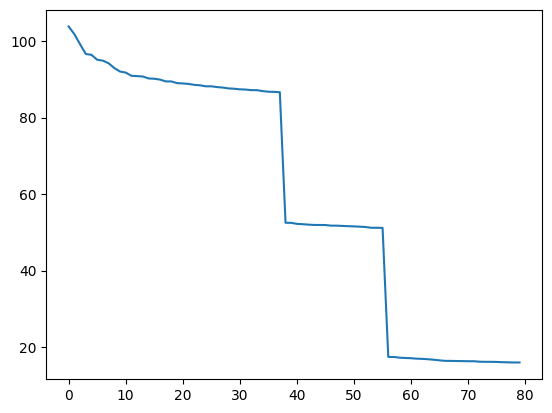

In [ ]:
toy1 = 'problems/toy/calle_del_virrey_morcillo_albacete_250_3_candidates_15_ns_4.json'
medium1 = 'problems/medium/calle_agustina_aroca_albacete_500_1_candidates_89_ns_22.json' 
medium2 = 'problems/medium/calle_palmas_de_gran_canaria_albacete_500_2_candidates_167_ns_23.json' #tarda mas
medium3 = 'problems/medium/calle_f_albacete_2000_0_candidates_25_ns_4.json'

large1 = 'problems/large/calle_cardenal_tabera_y_araoz_albacete_1000_2_candidates_104_ns_22.json'
large2 = 'problems/large/calle_del_virrey_morcillo_albacete_1000_1_candidates_598_ns_99.json'
large3 = 'problems/large/calle_herreros_albacete_1000_4_candidates_496_ns_14.json'
large4 = 'problems/large/calle_industria_albacete_1000_0_candidates_122_ns_8.json'
large5 = 'problems/large/calle_industria_albacete_1000_2_candidates_549_ns_71.json'

huge1 = 'problems/huge/calle_de_josé_carbajal_albacete_2000_2_candidates_1254_ns_110.json'
huge2 = 'problems/huge/calle_de_josé_carbajal_albacete_5000_2_candidates_537_ns_12.json'

RUTAJSON = large2

h1 = Heuristica1(Problema(RUTAJSON)) # Euclidea
h2 = Heuristica2(Problema(RUTAJSON)) # Geodesica. Más precisa, menor rendimiento
h3 = Heuristica3(Problema(RUTAJSON)) # Manhattan
h4 = Heuristica4(Problema(RUTAJSON)) # Harvesine. Ligeramente peor que Geodesica, aumenta rendimiento ligeramente para el evolutivo.

problema = Problema(RUTAJSON)
usarCacheIntermedia = False     # Coste menos preciso, mucho menor coste de rendimiento
aestrella = AEstrella(problema, h2, usarCacheIntermedia)

random.seed(777) # Para tener resultados reproducibles
print("Estaciones candidatas elegidas:")
#nGeneracionesMaximas, tamTorneo, tamPoblacion , tasaMutacion, tasaCruce
evolutivoTorneo(80, 8, 100, .1, 1, aestrella, problema).genetico()
#plt.show()